Found 1012 .wav files.
Example file: /content/Actor_01/03-02-01-01-01-01-01.wav
Class counts: calm       552
happy      552
angry      552
sad        552
fearful    552
neutral    276
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 2428, number of used features: 120
[LightGBM] [Info] Start training from score -1.705778
[LightGBM] [Info] Start training from score -1.703513
[LightGBM] [Info] Start training from score -1.705778
[LightGBM] [Info] Start training from score -1.705778
[LightGBM] [Info] Start training from score -2.396660
[LightGBM] [Info] Start training from score -1.703513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

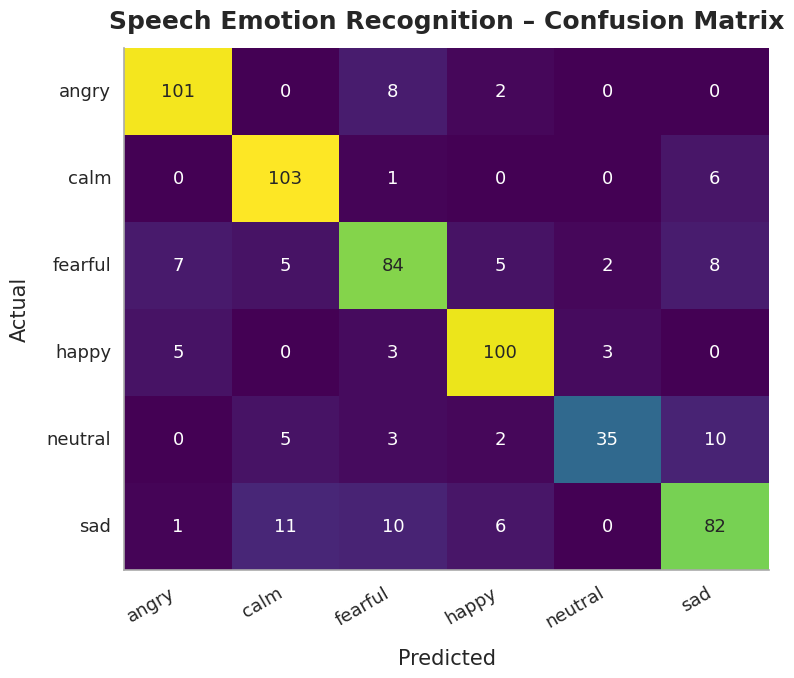

<Figure size 900x600 with 0 Axes>

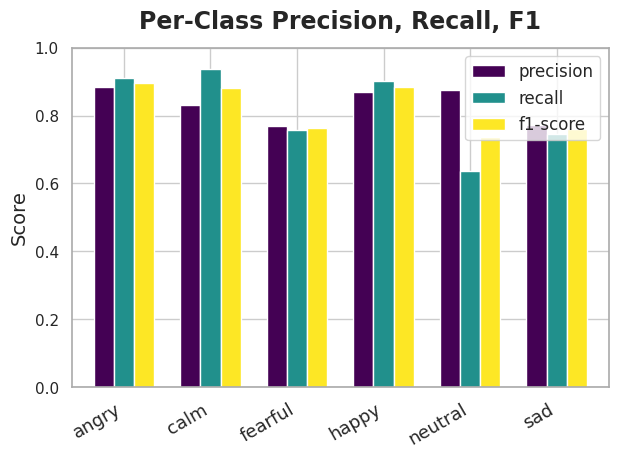

              precision    recall  f1-score   support

       angry       0.89      0.91      0.90       111
        calm       0.83      0.94      0.88       110
     fearful       0.77      0.76      0.76       111
       happy       0.87      0.90      0.88       111
     neutral       0.88      0.64      0.74        55
         sad       0.77      0.75      0.76       110

    accuracy                           0.83       608
   macro avg       0.83      0.81      0.82       608
weighted avg       0.83      0.83      0.83       608



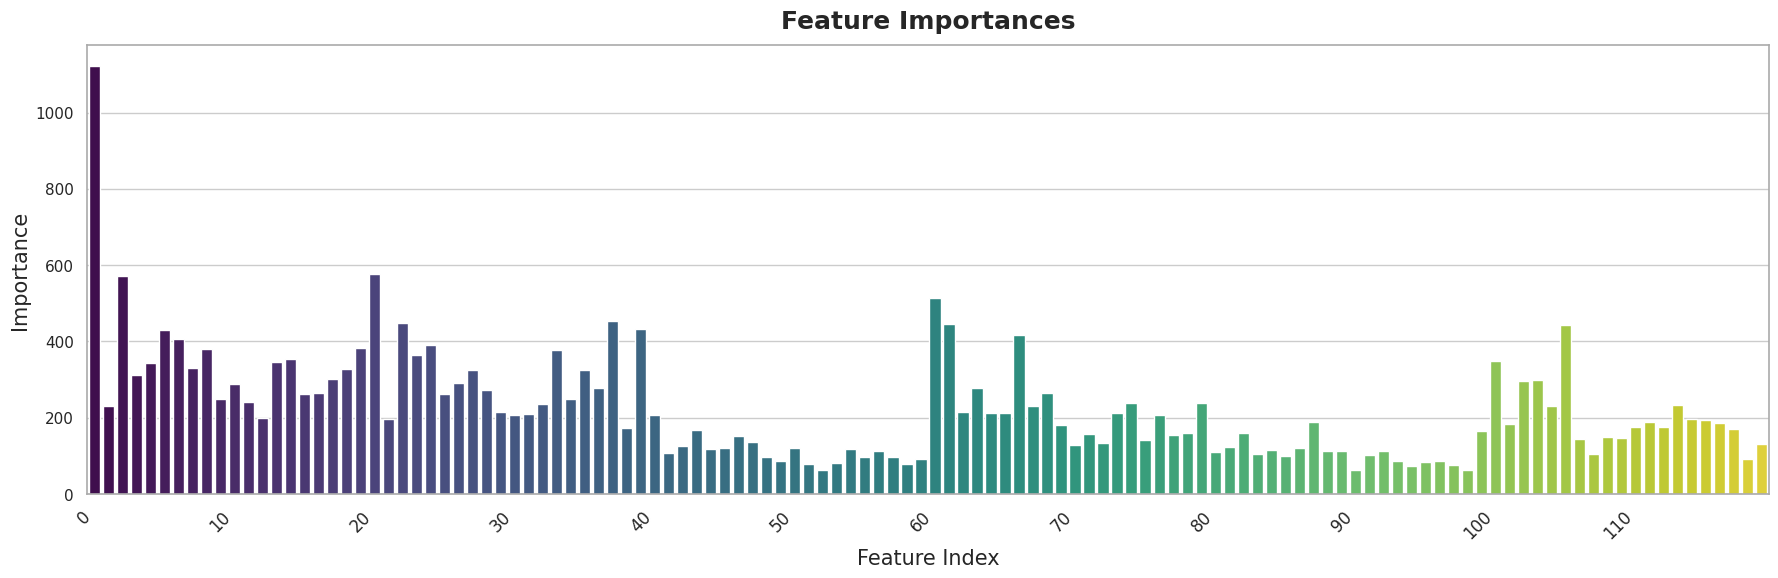

              precision    recall  f1-score   support

       angry       0.89      0.91      0.90       111
        calm       0.83      0.94      0.88       110
     fearful       0.77      0.76      0.76       111
       happy       0.87      0.90      0.88       111
     neutral       0.88      0.64      0.74        55
         sad       0.77      0.75      0.76       110

    accuracy                           0.83       608
   macro avg       0.83      0.81      0.82       608
weighted avg       0.83      0.83      0.83       608



In [ ]:
"""
Speech Emotion Recognition Pipeline
Author: Rhishi Kumar Ayyappan

- Handles any Audio_Song_Actors_01-24.zip upload/extraction structure in Colab
- Finds all actor folders & .wav files, regardless of extraction location
- Full ML pipeline, visualizations, and FastAPI deployment

Instructions are stored in the `usage` variable at the end.
"""

# ==============================
# SECTION 1: Colab ZIP Upload & Extraction
# ==============================
# 1. Upload your .zip via Colab UI (left panel → Files → Upload)
# 2. Extract zip
from zipfile import ZipFile
import os

uploaded_zip = "/content/Audio_Song_Actors_01-24.zip"  # Colab upload path
if os.path.exists(uploaded_zip):
    with ZipFile(uploaded_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/")
else:
    print("Upload your Audio_Song_Actors_01-24.zip first!")

# ==============================
# SECTION 2: Imports & Theme
# ==============================
!pip install python-multipart
import sys
!{sys.executable} -m pip install -q librosa fastapi uvicorn joblib imbalanced-learn lightgbm

import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from fastapi import FastAPI, UploadFile, File
import soundfile as sf
import io
import warnings
warnings.filterwarnings("ignore")

# Set global style (Viridis palette for all visuals)
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.15)
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.titleweight': 'bold',
    'legend.fontsize': 11,
    'axes.edgecolor': '#AAAAAA',
    'axes.linewidth': 1.2
})

# ==============================
# SECTION 3: Config & Utility
# ==============================
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
N_CLASSES = len(EMOTIONS)
MODEL_PATH = "/content/ser_model.joblib"
SCALER_PATH = "/content/ser_scaler.joblib"

# ==============================
# SECTION 4: Audio Feature Extraction
# ==============================
def extract_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=22050)
    if len(y) < sr:  # Pad or repeat to 1s
        y = np.tile(y, int(np.ceil(sr/len(y))))[:sr]
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    feat = np.concatenate([
        mfccs.mean(axis=1), mfccs.std(axis=1),
        mfccs_delta.mean(axis=1), mfccs_delta.std(axis=1),
        mfccs_delta2.mean(axis=1), mfccs_delta2.std(axis=1)
    ])
    return feat

def parse_emotion_from_filename(path):
    base = os.path.basename(path)
    parts = base.split("-")
    return EMOTIONS.get(parts[2], "unknown")

def pitch_shift_augment(path, n_steps=2):
    y, sr = librosa.load(path, sr=22050)
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    mfccs = librosa.feature.mfcc(y=y_shifted, sr=sr, n_mfcc=20)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    feat = np.concatenate([
        mfccs.mean(axis=1), mfccs.std(axis=1),
        mfccs_delta.mean(axis=1), mfccs_delta.std(axis=1),
        mfccs_delta2.mean(axis=1), mfccs_delta2.std(axis=1)
    ])
    return feat

# ==============================
# SECTION 5: Robust .wav Search for Colab Extraction
# ==============================
# Try both possible structures (with/without folder)
wav_files = sorted(glob("/content/**/*.wav", recursive=True))
if len(wav_files) == 0:
    wav_files = sorted(glob("/content/Audio_Song_Actors_01-24/**/*.wav", recursive=True))
print(f"Found {len(wav_files)} .wav files.")
print("Example file:", wav_files[0] if wav_files else "No files found.")

# ==============================
# SECTION 6: Data Loading & Augmentation
# ==============================
X_list, y_list = [], []
class_counts = {k:0 for k in EMOTIONS.values()}

for file_path in wav_files:
    emotion = parse_emotion_from_filename(file_path)
    if emotion not in EMOTIONS.values(): continue
    X_list.append(extract_features(file_path))
    y_list.append(emotion)
    class_counts[emotion] += 1
    # Augmentation: boost minority classes
    if class_counts[emotion] < 200:
        X_list.append(pitch_shift_augment(file_path, n_steps=2))
        y_list.append(emotion)
        X_list.append(pitch_shift_augment(file_path, n_steps=-2))
        y_list.append(emotion)

X = np.array(X_list)
y = np.array(y_list)
print("Class counts:", pd.Series(y).value_counts())

# ==============================
# SECTION 7: Train-Test Split & Scaling
# ==============================
if len(X) == 0:
    raise RuntimeError("No audio features extracted! Double-check that your .wav files are present and parsed correctly.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
joblib.dump(scaler, SCALER_PATH)

# ==============================
# SECTION 8: Model Training
# ==============================
try:
    model = lgb.LGBMClassifier(n_estimators=150, random_state=42)
    model.fit(X_train, y_train)
    print("LightGBM model used.")
except Exception:
    model = RandomForestClassifier(n_estimators=150, random_state=42)
    model.fit(X_train, y_train)
    print("RandomForest model used.")

joblib.dump(model, MODEL_PATH)

# ==============================
# SECTION 9: Evaluation & Visualizations
# ==============================
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.3f}")

# Confusion Matrix
# Section: Evaluation & Visualizations (patched)
present_classes = sorted(list(set(y_test) | set(y_pred)))
print("Present classes in this split:", present_classes)

cm = confusion_matrix(y_test, y_pred, labels=present_classes)
plt.figure(figsize=(8,7))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=False,
                 xticklabels=present_classes, yticklabels=present_classes,
                 annot_kws={"size": 13})
ax.set_xlabel("Predicted", fontsize=15, labelpad=12)
ax.set_ylabel("Actual", fontsize=15, labelpad=12)
ax.set_title("Speech Emotion Recognition – Confusion Matrix", fontsize=18, pad=14)
ax.set_xticklabels(present_classes, rotation=30, ha="right", fontsize=13)
ax.set_yticklabels(present_classes, rotation=0, fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()


# Classification Report (only for present classes)
report = classification_report(
    y_test, y_pred,
    labels=present_classes,
    target_names=present_classes,
    output_dict=True
)
report_df = pd.DataFrame(report).T.iloc[:-3, :]
plt.figure(figsize=(9,6))
colors = ['#440154', '#21908C', '#FDE725']  # Viridis color anchors
ax = report_df[['precision','recall','f1-score']].plot(
    kind="bar", color=colors, width=0.7)
plt.title("Per-Class Precision, Recall, F1", fontsize=17, pad=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=30, ha="right", fontsize=13)
plt.ylim(0, 1)
plt.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()

print(classification_report(
    y_test, y_pred,
    labels=present_classes,
    target_names=present_classes
))


# Feature Importance
if hasattr(model, "feature_importances_"):
    plt.figure(figsize=(18,6))  # Wider figure
    n_feats = len(model.feature_importances_)
    indices = np.arange(n_feats)
    ax = sns.barplot(x=indices, y=model.feature_importances_, palette="viridis")
    ax.set_title("Feature Importances", fontsize=18, pad=12)
    ax.set_xlabel("Feature Index", fontsize=15)
    ax.set_ylabel("Importance", fontsize=15)
# Show every 10th label, rotate for clarity
    ax.set_xticks(np.arange(0, n_feats, 10))
    ax.set_xticklabels([str(i) for i in range(0, n_feats, 10)], rotation=45, ha="right", fontsize=12)
    plt.tight_layout()
    plt.show()

print(classification_report(
    y_test, y_pred,
    labels=present_classes,
    target_names=present_classes
))

# ==============================
# SECTION 10: FastAPI Deployment
# ==============================
app = FastAPI(title="Speech Emotion Recognition API")

@app.post("/predict_emotion")
async def predict_emotion(file: UploadFile = File(...)):
    try:
        wav_bytes = await file.read()
        import soundfile as sf
        import io
        with sf.SoundFile(io.BytesIO(wav_bytes)) as s:
            y = s.read(dtype="float32")
            sr = s.samplerate
            if sr != 22050:
                y = librosa.resample(y, orig_sr=sr, target_sr=22050)
        mfccs = librosa.feature.mfcc(y=y, sr=22050, n_mfcc=20)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
        feat = np.concatenate([
            mfccs.mean(axis=1), mfccs.std(axis=1),
            mfccs_delta.mean(axis=1), mfccs_delta.std(axis=1),
            mfccs_delta2.mean(axis=1), mfccs_delta2.std(axis=1)
        ])
        scaler = joblib.load(SCALER_PATH)
        model  = joblib.load(MODEL_PATH)
        X_pred = scaler.transform([feat])
        pred = model.predict(X_pred)[0]
        proba = model.predict_proba(X_pred).max()
        return {"predicted_emotion": str(pred), "confidence": float(proba)}
    except Exception as e:
        return {"error": str(e)}

# To run locally in Colab:
# !uvicorn your_script:app --host 0.0.0.0 --port 8000

# ==============================
# SECTION 11: Usage & README (as variable)
# ==============================
usage = """
How to Use in Colab:
--------------------
1. Upload your Audio_Song_Actors_01-24.zip file via the Colab UI.
2. This notebook/script will automatically extract and find all .wav files.
3. Run all cells for training, evaluation, and deployment.
4. Start the FastAPI endpoint (if needed) with:
       !uvicorn your_script:app --host 0.0.0.0 --port 8000
5. POST .wav files to /predict_emotion for emotion inference.

Example (Python requests):
import requests
files = {'file': open('test.wav', 'rb')}
resp = requests.post("http://127.0.0.1:8000/predict_emotion", files=files)
print(resp.json())
"""
# print(usage)  # To display instructions
